In [1]:
import allel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pysam import VariantFile
from tqdm import tqdm
import numpy as np

In [2]:
vcf_dir = "data/1000G/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz"
def allele_indices(vcf_dir, skip_every = 5):
    """
    Given a VCF file, this returns each samples genotype 
    represented as allele indices along with the corresponding
    variant IDs and list of samples.

    Args:
        vcf_dir (string): Location of VCF file.
        skip_every (int): Only return every other "skip_every"
            variant. This may be useful if you are running this
            with less than 16GB of RAM.

    Returns:
        list: List of each sample.
        list: Genotypes of shape: (samples, num_variants // skip_every, 2).
        list: Variant IDs for each variant.

    """
    vcf_file = VariantFile(vcf_dir)

    samples = list(vcf_file.header.samples)

    genotypes = []
    variant_ids = []
    for counter, record in tqdm(enumerate(vcf_file.fetch())):
        if counter % skip_every == 0:
            alleles = [record.samples[x].allele_indices for x in samples]

            genotypes.append(alleles)
            variant_ids.append(record.id)

    return samples, genotypes, variant_ids

In [36]:
print(genotypes)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [3]:
panel_dir = "data/1000G/integrated_call_samples_v3.20130502.ALL.panel"
def parse_panel(panel_dir):
    """
    Returns python dictionaries that maps each sample
    to a population and superpopulation. 

    Args:
        panel_dir (string): Location of the panel file 
            containing information about each sample.

    Returns:
        dict: Population map for each sample. For
            example, {sample_id, population}.

        dict: Superpopulation map for each sample. For
            example, {sample_id, superpopulation}.

    """
    population_map = {}  
    superpopulation_map = {}  
    with open(panel_dir) as panel_file:
        for sample in panel_file:
            """
            EX: ["HG00607", "CHS", "ASN", "ILLUMINA"]

            sample[0] = Sample ID.
            sample[1] = Population.
            sample[2] = Superpopulation.

            """
            sample = sample.strip().split('\t')

            population_map[sample[0]] = sample[1]
            superpopulation_map[sample[0]] = sample[2]
    
    return population_map, superpopulation_map 

In [4]:
skip_every = 25
samples, genotypes, variant_ids = allele_indices(vcf_dir, skip_every)
population_map, superpopulation_map = parse_panel(panel_dir)

# Find the superpopulation of each sample.
superpopulation = pd.Series(samples).map(superpopulation_map)

# Prepare the data for dimensionality reduction.
# shape: (samples, variant_count // skip_every, 2)
genotypes = np.array(genotypes)
genotypes = np.sum(genotypes, axis = 2)

1103547it [01:36, 11430.33it/s]


In [5]:
genotypes = genotypes[::10]
genotypes.shape

(4415, 2504)

In [6]:
m, n = genotypes.shape

print(f"Shape: ({m}, {n})")
print(f"New Number of Alleles: {m}")
print(f"New Number of Sampled People: {n}")

Shape: (4415, 2504)
New Number of Alleles: 4415
New Number of Sampled People: 2504


In [7]:
# Calculate the mean.
mean = np.mean(genotypes, axis = 1, keepdims = True)

# Subtract the mean.
genotypes_normalized = genotypes - mean

# Compute the covariance matrix of our data.
covariance = genotypes_normalized.dot(genotypes_normalized.T) / (n - 1)

In [8]:
eig_values, eig_vectors = np.linalg.eigh(covariance)

# They are in ascending order, we want the opposite.
eig_values = eig_values[::-1]
eig_vectors = eig_vectors[:, ::-1]

print(eig_values.shape)
print(eig_vectors.shape)

(4415,)
(4415, 4415)


In [10]:
np.cumsum(eig_values / np.sum(eig_values))[0 : 10]

array([0.09475561, 0.13830854, 0.15512623, 0.17010558, 0.17905011,
       0.18635535, 0.19349178, 0.20013839, 0.20651528, 0.21268311])

In [11]:
pc1 = eig_vectors[:, 0]
pc2 = eig_vectors[:, 1]

In [12]:
pc1_plot = genotypes_normalized.T.dot(pc1)
pc2_plot = genotypes_normalized.T.dot(pc2)

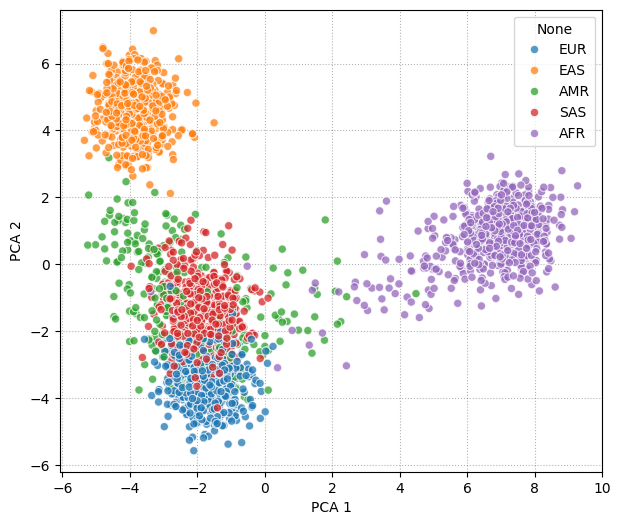

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (7, 6))

sns.scatterplot(
    x = pc1_plot, 
    y = pc2_plot, 
    hue = superpopulation,
    alpha = 0.75, 
    zorder = 2,
    linewidth = 0.75,
    ax = ax
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)

plt.show()

### Sckilearn

In [17]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components = 2)
pca_model.fit(genotypes.T)

pca_out = pca_model.transform(genotypes.T)
pca_out.shape

(2504, 2)

In [18]:
np.cumsum(pca_model.explained_variance_ratio_)

array([0.09475561, 0.13830854])

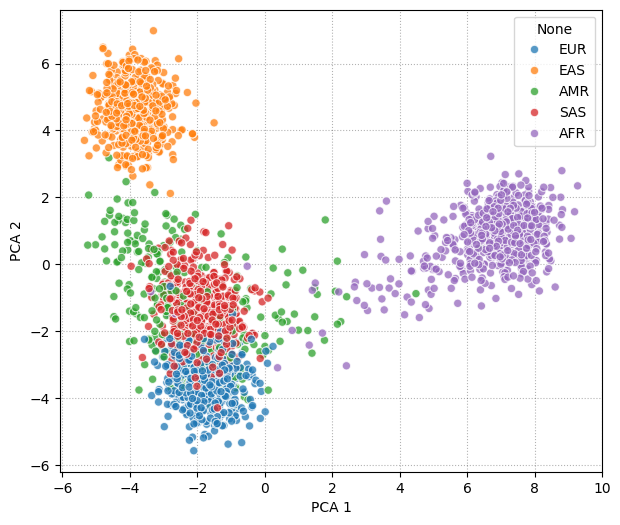

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (7, 6))

sns.scatterplot(
    x = pca_out[:, 0], 
    y = pca_out[:, 1], 
    hue = superpopulation, 
    alpha = 0.75, 
    zorder = 2,
    linewidth = 0.75,
    ax = ax
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)

plt.show()

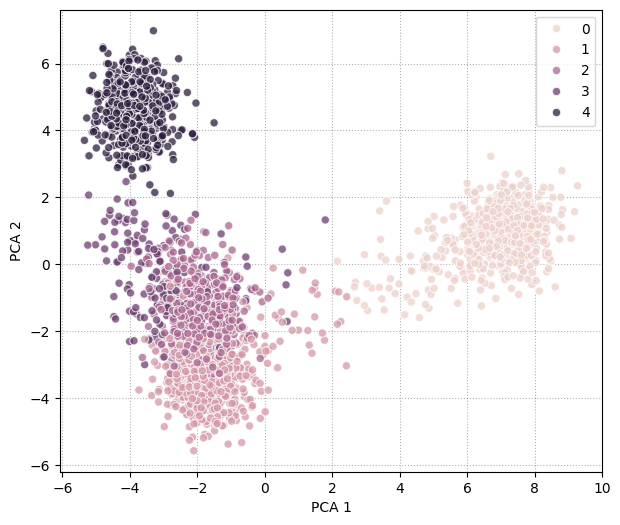

In [26]:
from sklearn.cluster import KMeans

pca_model = PCA(n_components = 128)

cluster_model = KMeans(n_clusters = 5, max_iter = 1000, n_init = 25)
cluster_model.fit(
    pca_model.fit_transform(genotypes.T)
)

fig, ax = plt.subplots(1, 1, figsize = (7, 6))

sns.scatterplot(
    x = pca_out[:, 0], 
    y = pca_out[:, 1], 
    hue = cluster_model.labels_, 
    alpha = 0.75, 
    zorder = 2,
    linewidth = 0.75,
    ax = ax
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)

plt.show()

In [27]:
variance_captured = np.cumsum(pca_model.explained_variance_ratio_)[-1]

print(f"Percentage of variance captured with {pca_model.n_components} components: {variance_captured:0.4f}")

Percentage of variance captured with 128 components: 0.5837


In [28]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def _make_cost_m(cm):
    return -cm + np.max(cm)

def cluster_accuracy(y_pred, y_true):
    """
    Gets the best permutation accuracy score for 
    y_pred and y_true.
    
    """
    cm = confusion_matrix(y_pred, y_true)
    
    indexes = linear_sum_assignment(_make_cost_m(cm))
    
    total = 0
    for row, column in zip(*indexes):
        value = cm[row][column]
        total += value

    return (total * 1.0 / np.sum(cm))

In [30]:
from sklearn.metrics import accuracy_score
true_values = superpopulation.map({
    "EUR": 0,
    "EAS": 1,
    "AMR": 2,
    "AFR": 3,
    "SAS": 4
}).values

cluster_accuracy(cluster_model.labels_, true_values)

0.9213258785942492